In [1]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!gdown https://drive.google.com/uc?id=0Bz8a_Dbh9QhbUDNpeUdjb0wxRms

Downloading...
From: https://drive.google.com/uc?id=0Bz8a_Dbh9QhbUDNpeUdjb0wxRms
To: /content/ag_news_csv.tar.gz
100% 11.8M/11.8M [00:00<00:00, 120MB/s]


In [3]:
%cd /content

/content


In [4]:
%ls

ag_news_csv.tar.gz  sample_data/


In [5]:
!tar -xzvf ag_news_csv.tar.gz 

ag_news_csv/
ag_news_csv/train.csv
ag_news_csv/test.csv
ag_news_csv/classes.txt
ag_news_csv/readme.txt


In [6]:
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt

#Text Color
from termcolor import colored

#Train Test Split
from sklearn.model_selection import train_test_split

#Model Evaluation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

#Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

In [7]:
tf.__version__

'2.11.0'

In [8]:
# File Path
TRAIN_FILE_PATH = '/content/ag_news_csv/train.csv'
TEST_FILE_PATH = '/content/ag_news_csv/test.csv'

csv_columns = ['ClassIndex', 'Title', 'Description']

# Load Data
data = pd.read_csv(TRAIN_FILE_PATH, names=csv_columns)
testdata = pd.read_csv(TEST_FILE_PATH, names=csv_columns)

# # Set Column Names 
# data.columns = ['ClassIndex', 'Title', 'Description']
# testdata.columns = ['ClassIndex', 'Title', 'Description']

# Combine Title and Description
X_train = data['Title'] + " " + data['Description'] # Combine title and description (better accuracy than using them as separate features)
y_train = data['ClassIndex'].apply(lambda x: x-1).values # Class labels need to begin from 0

x_test = testdata['Title'] + " " + testdata['Description'] # Combine title and description (better accuracy than using them as separate features)
y_test = testdata['ClassIndex'].apply(lambda x: x-1).values # Class labels need to begin from 0

# Max Length of sentences in Train Dataset
maxlen = X_train.map(lambda x: len(x.split())).max()
data.head()

,ClassIndex,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [9]:
testdata.head()

,ClassIndex,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [10]:
data.shape, testdata.shape

((120000, 3), (7600, 3))

In [11]:
# Checking Value counts to determine class balance
data.ClassIndex.value_counts()

3    30000
4    30000
2    30000
1    30000
Name: ClassIndex, dtype: int64

In [12]:
testdata.ClassIndex.value_counts()

3    1900
4    1900
2    1900
1    1900
Name: ClassIndex, dtype: int64

In [13]:
# Train Data
data.isnull().sum()

ClassIndex     0
Title          0
Description    0
dtype: int64

In [14]:
# Test Data
testdata.isnull().sum()

ClassIndex     0
Title          0
Description    0
dtype: int64

In [15]:
# Padding
vocab_size = 10000 # arbitrarily chosen
embed_size = 32 # arbitrarily chosen

# Create and Fit tokenizer
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X_train.values)

In [16]:
# Tokenize data
X_train = tok.texts_to_sequences(X_train)
x_test = tok.texts_to_sequences(x_test)

# Pad data
X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [17]:
model = Sequential()
model.add(Embedding(vocab_size, embed_size, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPooling1D()) #Pooling Layer decreases sensitivity to features, thereby creating more generalised data for better test results.
model.add(Dense(1024))
model.add(Dropout(0.25)) #Dropout layer nullifies certain random input values to generate a more general dataset and prevent the problem of overfitting.
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax')) #softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 177, 32)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 177, 256)         164864    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 177, 128)         164352    
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1024)              132096    
                                                        

In [18]:
callbacks = [
    # EarlyStopping is used to stop at the epoch where val_accuracy does not improve significantly
    EarlyStopping(     
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        # save_weights_only=True,
        verbose=1
    )
]

In [19]:
model.compile(loss='sparse_categorical_crossentropy', 
              #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer='adam', 
              metrics=['accuracy']) 

model.fit(X_train, 
          y_train, 
          batch_size=256, 
          validation_data=(x_test, y_test), 
          epochs=20, 
          callbacks=callbacks)

Epoch 1/20
469/469 [==============================] - ETA: 0s - loss: 0.3963 - accuracy: 0.8577
Epoch 1: val_accuracy improved from -inf to 0.91079, saving model to model.h5
469/469 [==============================] - 73s 124ms/step - loss: 0.3963 - accuracy: 0.8577 - val_loss: 0.2798 - val_accuracy: 0.9108
Epoch 2/20
469/469 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9234
Epoch 2: val_accuracy improved from 0.91079 to 0.91132, saving model to model.h5
469/469 [==============================] - 36s 77ms/step - loss: 0.2349 - accuracy: 0.9234 - val_loss: 0.2703 - val_accuracy: 0.9113
Epoch 3/20
469/469 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9348
Epoch 3: val_accuracy did not improve from 0.91132
469/469 [==============================] - 33s 70ms/step - loss: 0.1957 - accuracy: 0.9348 - val_loss: 0.2773 - val_accuracy: 0.9091
Epoch 4/20
469/469 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9437
Epoch 

In [20]:
def modelDemo(news_text):

  #News Labels
  labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

  test_seq = pad_sequences(tok.texts_to_sequences(news_text), maxlen=maxlen)

  test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]

  for news, label in zip(news_text, test_preds):
      # print('{} - {}'.format(news, label))
      print('{} - {}'.format(colored(news, 'yellow'), colored(label, 'blue')))

In [21]:
modelDemo(['New evidence of virus risks from wildlife trade'])

1/1 [==============================] - 2s 2s/step
New evidence of virus risks from wildlife trade - Science-Technology News


238/238 [==============================] - 3s 11ms/step


<Figure size 432x288 with 0 Axes>

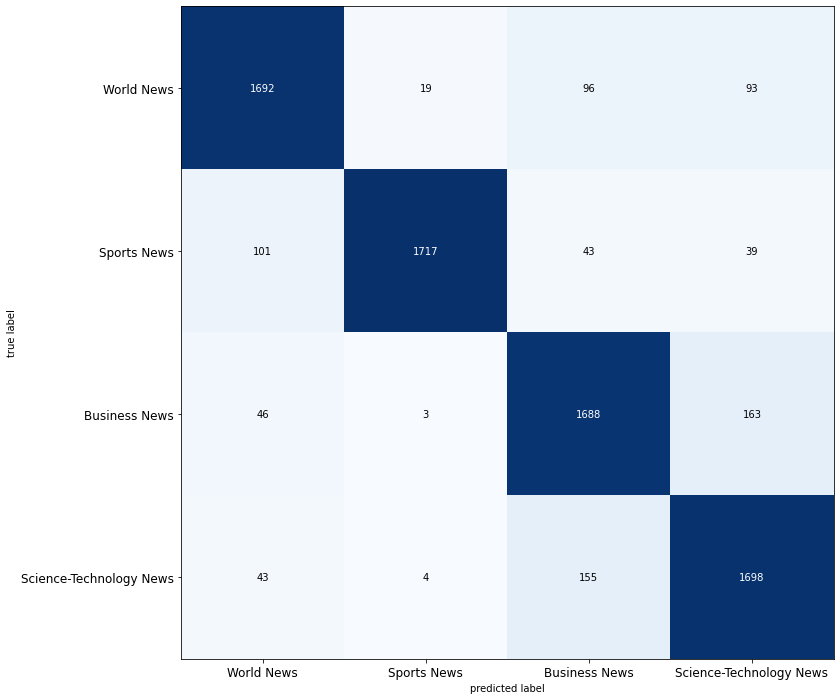

In [22]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
preds = [np.argmax(i) for i in model.predict(x_test)]
cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

In [23]:
print("Recall of the model is {:.2f}".format(recall_score(y_test, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_test, preds, average='micro')))
print("Accuracy of the model is {:.2f}".format(accuracy_score(y_test, preds)))

Recall of the model is 0.89
Precision of the model is 0.89
Accuracy of the model is 0.89
